# Imports

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import pandas as pd
from PIL import Image
import timm
from imblearn.over_sampling import SMOTE

# Preprocessing

In [101]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_df = pd.DataFrame(train)
train_df = train_df.loc[np.where(train_df['original']==1)] # remain original is 1
# features[0] => gender
# features[1] => age
# timestamp_day
# timestamp_hour
# original => flag of is there any feature[2:-3]
# Non-existent data should be replaced with average values to minimize the impact on the classifier results.

train_df.iloc[:, 0:2] = train_df.iloc[:, 0:2].fillna(round(train_df.iloc[:, 0:2].mean()))
train_df.iloc[:, 2:34] = train_df.iloc[:, 2:34].fillna(train_df.iloc[:, 2:34].mean())

# fix the class, to change (-4, -5) to -3
train_df.iloc[:, -3] = train_df.iloc[:, -3].replace([-4, -5], -3)

train_X = train_df.iloc[:, 0:34]
train_y = train_df.iloc[:, -3]

# data balancing with SMOTE
sm = SMOTE(sampling_strategy='auto', random_state=2023)
train_X, train_y = sm.fit_resample(train_X, train_y)
train_X.iloc[:, 0:2] = round(train_X.iloc[:, 0:2])
train_y = round(train_y)

train_X

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,0.0,62.0,65.213491,116.401456,97.710257,20.745451,36.999239,0.020000,0.30000,131.349639,...,7.400000,10.00000,6.100000,78.600000,59.355618,10.900000,127.512195,4.110000,13.600000,7.750000
1,0.0,62.0,63.000000,106.000000,106.000000,19.000000,37.000000,0.041682,0.38787,131.349639,...,4.557596,9.71284,10.736873,81.104594,59.355618,12.425312,127.512195,3.180244,16.068297,12.191436
2,0.0,62.0,94.000000,144.000000,97.710257,20.745451,36.999239,0.041682,0.38787,131.349639,...,4.557596,9.71284,10.736873,81.104594,59.355618,12.425312,127.512195,3.180244,16.068297,12.191436
3,0.0,62.0,88.000000,113.000000,94.000000,15.000000,36.999239,0.041682,0.38787,131.349639,...,4.557596,9.71284,10.736873,81.104594,59.355618,12.425312,127.512195,3.180244,16.068297,12.191436
4,0.0,62.0,83.000000,96.000000,98.000000,20.000000,36.300000,0.041682,0.38787,131.349639,...,4.557596,9.71284,10.736873,81.104594,59.355618,12.425312,127.512195,3.180244,16.068297,12.191436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252335,0.0,44.0,74.351562,104.351562,61.013671,16.675781,37.136523,0.041682,0.38787,131.349639,...,4.557596,9.71284,10.736873,81.104594,59.355618,12.425312,127.512195,3.180244,16.068297,12.191436
252336,1.0,66.0,65.213491,116.401456,97.710257,20.745451,36.392304,0.041682,0.38787,131.349639,...,4.557596,9.71284,10.736873,81.104594,59.355618,12.425312,127.512195,3.180244,16.068297,12.191436
252337,0.0,65.0,68.301400,118.849300,124.397199,26.849300,38.189020,0.041682,0.38787,131.349639,...,4.557596,9.71284,10.736873,81.104594,59.355618,12.425312,127.512195,3.180244,16.068297,12.191436
252338,0.0,50.0,94.437142,134.125716,127.000000,25.125716,37.674857,0.041682,0.38787,131.349639,...,4.557596,9.71284,10.736873,81.104594,59.355618,12.425312,127.512195,3.180244,16.068297,12.191436


# EDA


In [102]:
# 1) How many patients are there?
print("Number of patients is {}".format(len(train_X)))

# 2) What are the mean and median value of the label (day)?
print("Mean of Label(day) : {}".format(train_y.mean()))
print(train_y)
print("Median of Label(day) : {}".format(np.median(train_y)))

print("Mean of each features")
print(np.mean(train_X))

print("Standard deviation of each features")
print(np.std(train_X))
# 3) Perform EDA and calculate the statistics of the dataset: mean, std, correlations among features

Number of patients is 252340
Mean of Label(day) : -1.5
0        -3.0
1        -3.0
2        -3.0
3        -3.0
4        -3.0
         ... 
252335   -1.0
252336   -1.0
252337   -1.0
252338   -1.0
252339   -1.0
Name: timestamp(day), Length: 252340, dtype: float64
Median of Label(day) : -1.5
Mean of each features
1       0.606416
2      65.532761
3      65.262405
4     116.658734
5      97.741894
6      20.751301
7      36.993255
8       0.041599
9       0.387273
10    131.304945
11      9.640721
12     11.624324
13      0.104104
14      1.126810
15     29.455720
16      9.850684
17      0.154300
18      1.572188
19      0.761003
20     11.592385
21     31.149899
22     33.543390
23     92.966512
24      0.474926
25      4.554472
26      9.712732
27     10.730967
28     81.108728
29     59.350910
30     12.424979
31    127.512564
32      3.180107
33     16.068557
34     12.179316
dtype: float64
Standard deviation of each features
1      0.488544
2     13.893072
3     13.494995
4     25.47

correlation between features


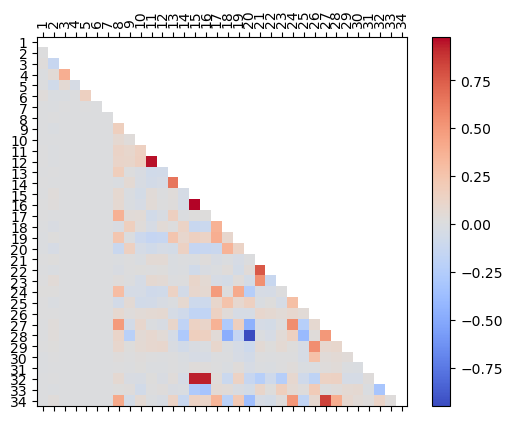

In [103]:
features = train_df.iloc[:, 0:34]

# Calcuate correlation between features
corr_matrix = features.corr()

# mask for show only upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix_masked = corr_matrix.mask(mask)


fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix_masked, cmap='coolwarm')
fig.colorbar(cax)

# Set the labels for the x-axis and y-axis.
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)

# Show the plot.
print("correlation between features")
plt.show()

In [104]:
# positive correlation high : 12/11, 16/15, 32/15, 32/16,
# negative correlation high : 28/20
# we can delete, 15, 16, 11, 20
train_df_feature_reduced = train_df.drop(columns=['11', '15', '16', '20'])
print(train_df_feature_reduced)


          1     2          3           4           5          6          7  \
0       0.0  62.0  65.213491  116.401456   97.710257  20.745451  36.999239   
2       0.0  62.0  63.000000  106.000000  106.000000  19.000000  37.000000   
4       0.0  62.0  94.000000  144.000000   97.710257  20.745451  36.999239   
8       0.0  62.0  88.000000  113.000000   94.000000  15.000000  36.999239   
9       0.0  62.0  83.000000   96.000000   98.000000  20.000000  36.300000   
...     ...   ...        ...         ...         ...        ...        ...   
245996  1.0  69.0  65.213491  116.401456   49.000000  20.000000  36.200000   
245997  1.0  69.0  65.213491  116.401456   50.000000  20.000000  36.400000   
245998  1.0  69.0  74.000000  173.000000   97.710257  20.745451  36.999239   
245999  1.0  69.0  65.213491  116.401456   47.000000  20.000000  36.700000   
246000  1.0  69.0  67.000000  155.000000   46.000000  22.000000  36.400000   

               8        9          10  ...         28         2

# Model Selection



# Model Tuning



# Model Evaluation / Metrics